In [1]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `SH_CLIENT_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`, `SH_INSTANCE_ID`

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
* `DAPA_URL`
* `DB_HOST`, `DB_NAME`, `DB_PASSWORD`, `DB_USER`
* `OGC_EDC_URL`
* `REFERENCE_DATA`


In [2]:
from edc import check_compatibility
check_compatibility("user-0.23.1")

# Impact of Covid19 induced lockdown on NO2 levels 

- Countries have initiated lockdown measures to control the spread of the disease 
- Not all of the measures were successful (Italy) 
- Countries (Germany) which successful implemented a lockdown showed a marked decrease in NO2 levels 

- NO2 is produced when fossil fuels are burned, as during transportation (cars, trucks etc. ) or 
- due to other economic activities (like factories )


## Load required dependencies & credentials

In [3]:
# Import required packages

from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
import xarray as xr

from sentinelhub import BBox, WmsRequest, DataSource, SHConfig
from functools import partial

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt


In [4]:
# Set Sentinel Hub credentials

import os
sh_credentials = dict(client_id=os.environ['SH_CLIENT_ID'],
                      client_secret=os.environ['SH_CLIENT_SECRET']) # This is only provided when the Oauth credentials are created

# Sentinel-3 OLCI, Sentinel-3 SLSTR and Sentinel-5 layers are processed on different infrastructure, 
# which requires to used different end-point

sh_credentials.update(api_url='https://creodias.sentinel-hub.com') 

## Core function to calculate NO2 values

NO2 values are calculated over the given period (Jan -May) for 2020 & 2019

In [5]:
def caculateNO2(geometry, timerange):
    """
    parameters:
    geometry: BBox object to be passed. This contains the bounding box for the area of interest (AOI)
    timerange: list giving the start & end of the time range format: YYYY-mm-dd
    
    return:
    a dataframe with two columns: Mean NO2 and Timestamp
    NO2 mean values for the time span between given timerange 
    
    """
    cube_config = CubeConfig(dataset_name='S5PL2',
                         band_names=['NO2'],
                         tile_size=[512, 512],
                         geometry=geometry,
                         spatial_res=abs(bbox[2]-bbox[0])/512,
                         time_range= timerange,
                         time_period='3D') 
    cube = open_cube(cube_config, **sh_credentials)

    no2_values = list() 
    timestamp = list()

    for i in range(cube.time.shape[0]):
        no2_values.append(np.nanmean(cube.NO2.isel(time=i).values[0]))
        timestamp.append(cube.NO2.isel(time=i).time.values)
        
    assert len(no2_values) == len(timestamp)
    
    return pd.DataFrame({'DateTime': timestamp, 'Mean NO2': no2_values})

## Read area of interest as a csv file
*Uncomment the next code block if you want to read the AOI from a csv file*

File has the following columns:
- Country: Name of country/territory of interest
- x1, y1 : Upper left corner co-ordinates (lat/lon)
- x2, y2 : Lower right corner co-ordinates

In [6]:
# aoi = pd.read_csv('AOI.csv')
# print(aoi.shape)
# print(aoi.head(8))

# shape = aoi.shape
# nullCount = sum(aoi.isna().sum())
# print(f"Shape of 2020 DF: {shape}, Count of Null values: {nullCount}".format(shape , nullCount ))

## Define AOI as a list

*This is a list of dictionaries with the required information*

Each dict has the following keys:

- Country: Name of country/territory of interest
- x1, y1 : Upper left corner co-ordinates (lat/lon)
- x2, y2 : Lower right corner co-ordinates

In [7]:
aoi = list()

#Define two dicts
country1 = dict()
country1['Country'] = 'Italy'
country1['x1'] = 46.28 
country1['y1'] = 6.42
country1['x2'] = 37.25
country1['y2'] = 19.73
aoi.append(country1)

country2 = dict()
country2['Country'] = 'Germany'
country2['x1'] = 54.77 
country2['y1'] = 4.70
country2['x2'] = 47.63
country2['y2'] = 15.73
aoi.append(country2)

#print(len(aoi))

## Main loop 

We iterate over each row in the `aoi.csv` file 

Sentinel-5P data for each defined AOI cube is extracted 

NO2 values for each tile is then averaged & stored in a list

For the purpose of this demo we will calculate the NO2 values for one AOI and for one month 
(*That will ensure that we don't exceed the timelimit of 10mins!*)

In [8]:
import time 

start = time.time()
aoi_no2 = list()

# Check length of provided aoi list OR dataframe
len_aoi = len(aoi)

# Define how many AOIs you want to process. For the demo we will use only one 
counter = 1

for idx in range(counter):
    aoi_dict = dict()
    
    # Check if aoi is passed as a list or a dataframe
    if isinstance(aoi, list):
        aoi_dict['Country_BBox'] = aoi[idx]['Country']
        x1 = int(aoi[idx]['x1'])  # degree 
        y1 = int(aoi[idx]['y1'])  # degree
        x2 = int(aoi[idx]['x2'])  # degree
        y2 = int(aoi[idx]['y2'])  # degree
                
    else:
        aoi_dict['Country_BBox'] = aoi.loc[idx]['Country']
        print("Processing: ", aoi_dict['Country_BBox'])
        x1 = int(aoi.loc[idx]['x1'])  # degree 
        y1 = int(aoi.loc[idx]['y1'])  # degree
        x2 = int(aoi.loc[idx]['x2'])  # degree
        y2 = int(aoi.loc[idx]['y2'])  # degree

    bbox = x1, y1, x2, y2
    timerange = ['2020-01-01', '2020-01-31']
    aoi_dict['NO2_2020'] = caculateNO2(bbox, timerange)
    shape = aoi_dict['NO2_2020'].shape
    nullCount = sum(aoi_dict['NO2_2020'].isna().sum())
    print(f"Shape of 2020 DF: {shape}, Count of Null values: {nullCount}".format(shape , nullCount ))    
    
    timerange = ['2019-01-01', '2019-01-31']
    aoi_dict['NO2_2019'] = caculateNO2(bbox, timerange)
    shape = aoi_dict['NO2_2019'].shape
    nullCount = sum(aoi_dict['NO2_2019'].isna().sum())
    print(f"Shape of 2019 DF: {shape}, Count of Null values: {nullCount}".format(shape , nullCount ))

    aoi_no2.append(aoi_dict)

end = time.time()
#print(len(aoi_no2))


/opt/conda/envs/eurodatacube-0.23.1/lib/python3.8/site-packages/xcube_sh/config.py:96: UserWarning: the geometry parameter is no longer supported, use bbox instead
  warnings.warn('the geometry parameter is no longer supported, use bbox instead')


Shape of 2020 DF: (11, 2), Count of Null values: 0


/opt/conda/envs/eurodatacube-0.23.1/lib/python3.8/site-packages/xcube_sh/config.py:96: UserWarning: the geometry parameter is no longer supported, use bbox instead
  warnings.warn('the geometry parameter is no longer supported, use bbox instead')


Shape of 2019 DF: (11, 2), Count of Null values: 0


In [9]:
print("Total processing time: {:.2} mins".format((end-start)/60)) 

Total processing time: 0.85 mins


The list is then pickled so that the information can then be reused in another run

In [10]:
import pickle 
#print(len(aoi_no2))
with open('aoi_list_no2.pkl', 'wb') as f:
    pickle.dump(aoi_no2, f)

## Plotting function

This plots the NO2 values over time

In [11]:
import matplotlib.pyplot as plt

def plot_no2(idx):
    """
    parameters:
    idx: Input id for accessing NO2 data 
    
    return:
    None
    line plots for NO2 (2020 vs 2019) are generated
    """

    plt.plot(aoi_no2[idx]['NO2_2020']['DateTime'], aoi_no2[idx]['NO2_2020']['Mean NO2'],  label = 'NO2 levels (2020)')
    plt.plot(aoi_no2[idx]['NO2_2020']['DateTime'], aoi_no2[idx]['NO2_2019']['Mean NO2'], label = 'NO2 levels (2019)')
    plt.ylabel('NO2 Levels')
    plt.xlabel('Month')
    plt.title('NO2 levels for '+ aoi_no2[idx]['Country_BBox'])
    plt.legend()
    plt.savefig(aoi_no2[idx]['Country_BBox']+'.png')
    plt.show()

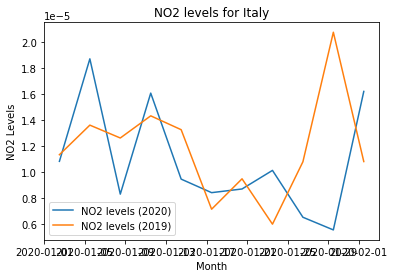

In [12]:
for idx in range(len(aoi_no2)):
    plot_no2(idx)
